## Speeding Up
- The part in QPE where we actually apply the phase kickback can be sped up using binary exponentiation over the Unitary matrix.
- When we are applying the matrix 2^(k-1) times to get a phase kickback, what we can do instead, is calculate the matrix 
    $$ U^{2^{k-1}}$$ using binary exponentiation and then use that as a **single** rotation gate instead of $$ O(2^{n}) $$ gates
- This would surely improve the circuit performance as it would improve circuit fidelity
- **NOTE** : this is just applicable when we want a simulation of our QPE algorithm and this is not representative of true phase estimation.
- This is because the classical computer would have to go inside the matrix representation of the unitary gate and if it can, it might as well determine the phase classically.

In [48]:
from qiskit import *
import matplotlib.pyplot as plt
from qiskit.extensions import UnitaryGate
from qiskit.circuit import add_control
from qiskit.tools.visualization import plot_bloch_multivector, plot_histogram
import numpy as np
from qiskit_textbook.tools import array_to_latex

In [49]:
class fast_QPE():
    '''
     Implements the vanilla QPE algorithm utilising the Inverse Fourier Transform
    and Phase Kickbacks.

      Attributes :
          precision : int([1,...]): precision of the phase estimation ( also equal to number of qubits in scratch register)
          unitary(np.ndarray or QuantumCircuit or UnitaryGate): unitary operator for which QPE is being applied.
          rotations(dict): contains the rotation angles required for the IQFT procedure
                      key : stage number, value : angle value
          powers(dict): contains the powers of the unitary matrix
                      key : exponent, value : U^(exponent)
          controls(dict): contains equivalent controlled U gates to be applied
                      key : qubit_index, value : controlled U gate
      Methods :
          get_rotations() : generate rotation values for the implementation of Inverse QFT
          binary_exp(U,n) : generates powers of U from U^1 -> U^(2^n) and stores in powers dict
          get_controls(unitary,n_qubits,exponent) : generates the U^(2^j) control gates for
                           faster simulation of the QPE algorithm
          get_QFT(n_qubits,swaps,show) : generate an n_qubit Quantum Fourier Transform
          get_QPE(show) : generate the final QPE circuit to be attached to the user's quantum circuit
    '''
        
        
    def __init__(self,precision,unitary):
        '''
        Args :
            precision(int) : The precision upto which the phase needs to be estimated.
                             Interpreted as 2^(-precision).
                             eg. precision = 4 means the phase is going to be precise
                                 upto 2^(-4).
            unitary(np.ndarray or UnitaryGate or QuantumCircuit):
                            The unitary for which we want to determine the phase. Currently
                            this class supports 2 x 2 matrices or single qubit gates.
                            Shall be extended for higher order matrices.
        Raises :
            TypeError : if precision or unitary are not of a valid type
            ValueError : if precision is not valid
            Exception : if unitary is of larger size than 2 x 2

        Examples :
            from basic_QPE import fast_QPE
                # passing as ndarray
                theta = 1/5
                U1 = np.ndarray([[1,0],
                                [0, np.exp(2*np.pi*1j*(theta))]])
                qpe1 = fast_QPE(precision = 4, unitary = U1)

                # passing as QuantumCircuit
                U2 = QuantumCircuit(1)
                U2.rz(np.pi/7,0)
                qpe2 = fast_QPE(precision = 5,unitary = U2)

        '''
        # handle precision
        if type(precision) != int:
            raise TypeError("Precision needs to be an integer")
        elif precision<0 or precision == 0:
            raise ValueError("Precision needs to be atleast 1")
            
        self.precision = precision 
        self.powers = {}
        self.controls = {}
        #handle unitary 
        if not isinstance(unitary,np.ndarray) and not isinstance(unitary,UnitaryGate) and not isinstance(unitary,QuantumCircuit):
            raise TypeError("A numpy array, UnitaryGate or QuantumCircuit needs to be passed as the unitary matrix")
        
        if isinstance(unitary,np.ndarray):
            self.unit_qubits = int(np.log2(unitary.shape[0]))
        else:
            self.unit_qubits = unitary.num_qubits 
            
        self.unitary = unitary 
        self.rotations = self.get_rotations()
        
        
        
    def get_rotations(self):
        '''Returns a dictionary of the angles associated with 
           each rotation gate upto precision specified '''
        rots = {}
        for k in range(1,self.precision):
            rots[k] = np.pi/(2**k)
        return rots 
    
    def binary_exp(self,U,n):
        '''This function returns the matrix U^(n) and saves 
           other smaller powers 
            
        Arguments: 
            U(np.ndarray): 
                The Unitary matrix which needs to be exponentitated 
            n(int): integer specifying the exponent 
            
        Raises:
            ValueError : when n is < 0 
        Returns: 
            a dictionary containing the relevant powers of the matrix U '''
        if n < 0:
            raise ValueError("Power should be atleast 0")
        if n==1:
            self.powers[1] = U 
            return self.powers[1]
        if n==0:
            return np.identity(2)
        if n%2 == 1:
            # if odd 
            if (n-1) not in self.powers:
                self.powers[n-1] = self.binary_exp(U,n-1)
                
            self.powers[n] = U @ self.powers[n-1]
            return self.powers[n]
        else:
            # if even
            if n/2 not in self.powers:
                self.powers[n/2] = self.binary_exp(U,n/2)
            
            self.powers[n] = self.powers[n/2] @ self.powers[n/2]
            return self.powers[n]
        
        
    def get_QFT(self,n_qubits :int ,show = False,swaps = True):
        '''Returns an n_qubits QFT circuit 
        
         Arguments :
             n_qubits : the number of qubits 
             show : whether to draw the circuit 
             swaps : whether swaps need to be performed at the 
                     end of the procedure 
           
         Returns :
             QuantumCircuit : the QuantumCircuit containing the QFT circuit
        '''
        
        if n_qubits <= 0:
            raise ValueError("Number of qubits must be > 0 ")
        
        qc = QuantumCircuit(n_qubits)
        for target in range(n_qubits):
            # apply hadamard
            qc.h(target) 
            # add rotations 
            rot = 1
            for control in range(target+1,n_qubits):
                qc.cp(self.rotations[rot],control,target)
                rot+=1 
        if swaps:
            ## add swap gates 
            i,j = 0, n_qubits-1 
            while (i<j):
                qc.swap(i,j)
                i+=1 
                j-=1 
            
        if show:
            print("Circuit for QFT of "+str(n_qubits))
            display(qc.draw('mpl'))
        return qc 
    
    def get_controls(self,unitary,n_qubits,exponent):
        '''Get the control gates for the circuit
         While computing exponent, we also 
         compute the smaller powers
         
         Arguments: 
             unitary : Unitary matrix given by the user 
             n_qubits : the number of qubits that are needed ( equals the amount of precision)
             exponent : the largest exponent value , is equal to 2**(n_qubits - 1)
             
        Returns: 
            controls(dict) : dictionary containing the relevant controlled unitary gates
                            key : qubit_index, value : controlled U gate 
             '''
             
        # Qubit i gets the phase kickback of 
        # 2^i 
        
        # generate the unitaries
        self.binary_exp(unitary,exponent)
        
        # self.controls has 1 based index
        controls = {}
        power = 1 
        for qubit in range(n_qubits):
            c = UnitaryGate(data = self.powers[power])
            cu = c.control(num_ctrl_qubits = 1,label = 'CU',ctrl_state = '1')
            controls[qubit] = cu 
            power *= 2
        
        return controls 
    
    def get_QPE(self,show = False):
        '''Returns the final QPE circuit to the user in form of a 
        QuantumCircuit 
        
        Arguments :
            show(bool) : Whether to draw the circuit or not 
            
        Returns : 
            QuantumCircuit : The QuantumCircuit which can be attached to the user circuit
          
        Usage Notes : 
        NOTE1: The last qubits of the circuit which is returned, need to be attached to the qubits 
               containing the EIGENVECTOR of the unitary that is passed. 
               The phase is encoded in the scratch qubits above the target qubit.
               
            For example :- 
                If precision is specified as 4 and a 6qubit QuantumCircuit contains the 
                eigenvector in the 5th qubit.
                unitary = np.ndarray([[1,0],
                [0, np.exp(2*np.pi*1j*(theta))]])
                q = QuantumCircuit(6,4)
                
                q.x(4) # the eigenvector qubit 
                
                qpe = fast_QPE(precision = 4,unitary = unitary)
                qpe_circ = qpe.get_QPE(show = True)
                q.append(qpe_circ, qargs = [0,1,2,3,4]) # last qubit is the eigenvector 
                q.draw('mpl')
        
        NOTE2: The phase is assumed to be a binary fraction as 0.x1x2x2...xn where n  
               is the precision specified by the user.
               The least significant bit , xn, is saved in the qubit with index 
               t - precision and the most significant bit, x1, is saved in the 
               qubit with index t - 1 where t is the index of the first target qubit 
               containing the EIGENVECTOR of the unitary. 
               
            For example :-
                theta = 1/5  # binary representation upto 4 bits : 0.0011
                
                unitary = np.ndarray([[1,0],
                [0, np.exp(2*np.pi*1j*(theta))]])
                
                q = QuantumCircuit(6,4)
                q.x(4) # the eigenvector qubit
                
                qpe = fast_QPE(precision = 4,unitary = unitary)
                qpe_circ = qpe.get_QPE(show = True)
                q.append(qpe_circ, qargs = [0,1,2,3,4])
                q.draw('mpl')
                # let '0011' be the state with highest probability after 
                # measurement
                # q[0] would contain 1 
                # q[1] would contain 1
                # q[2] would contain 0 
                # q[3] would contain 0  where q refers to the qubit 
                
        '''
        qc = QuantumCircuit(self.precision + self.unit_qubits,name = 'fast_QPE_circ')
        
        # generate the controlled Unitary gate and start applying it according 
        # to the orientation specified 
        if isinstance(self.unitary,QuantumCircuit):
            U = execute(self.unitary,backend = Aer.get_backend('unitary_simulator')).result().get_unitary()
        elif isinstance(self.unitary,UnitaryGate):
            U = self.unitary.to_matrix()
        else:
            U = self.unitary 
            
        # generate the binary exponent of the matrix 
        n_qubits = self.precision
        exp = 2**(n_qubits-1)
        
            
        # updates the self.controls dictionary
        self.controls = self.get_controls(U,n_qubits,exp)
        
        # add hadamard transform 
        qc.h([i for i in range(self.precision)])
        
        ## attach control gates
        target = [i + self.precision for i in range(self.unit_qubits)]
        for i in range(n_qubits):
            control = i 
            qc = qc.compose(self.controls[i],qubits = [control] + target)
        qc.barrier()
            
        # attach IQFT 
        IQFT = self.get_QFT(n_qubits,show= show,swaps = False).inverse()
        IQFT.name = "IQFT"
        
        ## add swap gates 
        i,j = 0, n_qubits-1 
        while (i<j):
            IQFT.swap(i,j)
            i+=1 
            j-=1 
        
        #append circuit 
        qc.append(IQFT,qargs = [i for i in range(self.precision)])
        
        # that's it 
        if(show == True):
            display(qc.draw('mpl'))
        return qc 
            
        

## Making the Circuit
- The circuit is reduced to 4 unitaries instead of 15 
- The phase to be estimated is 0.2

In [50]:
U = np.array([[1, 0],
              [0, np.exp(2*np.pi*1j*(1/5))]])

Circuit for QFT of 4


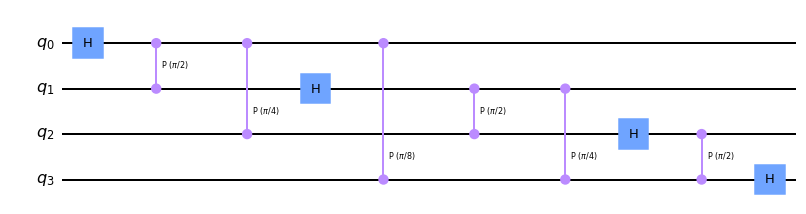

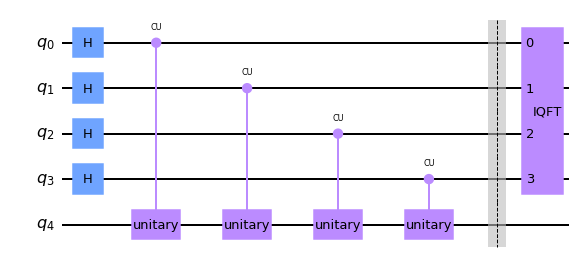

In [51]:
qpe_circ = fast_QPE(precision=4, unitary=U).get_QPE(show=True)

## Attaching the circuit

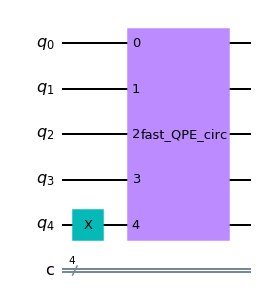

In [42]:
q = QuantumCircuit(5, 4)
q.x(4)
q.append(qpe_circ, qargs=[0, 1, 2, 3, 4])
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

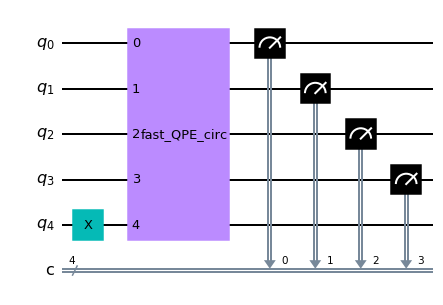

In [43]:
q.measure([0, 1, 2, 3], [0, 1, 2, 3])
q.draw('mpl')

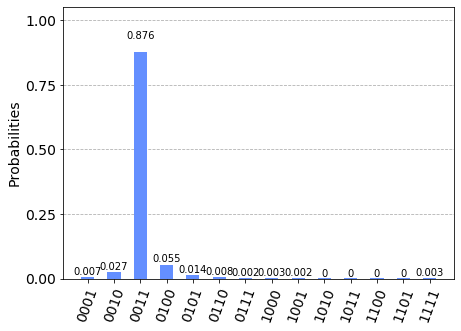

In [44]:
count = execute(q, backend=Aer.get_backend(
    'qasm_simulator')).result().get_counts()
plot_histogram(count)

- Yes! this is a correct circuit which actually used exponentially less gates to produce the same outputs

## Testing 3 qubit circuit
- Using a 2 qubit CP gate with $\theta = \frac {1}{7} $ is used to estimate the phase of the 2 qubit unitary
- Again, the phase is represented upto 4 bit precision as : 
$$\theta = 0.0010$$

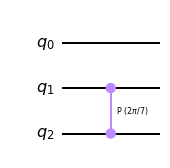

In [35]:
q = QuantumCircuit(3,name = 'Unitary')
q.cp(2*np.pi*(1/7),1,2)
display(q.draw('mpl'))
# u = execute(q,backend = Aer.get_backend('unitary_simulator')).result().get_unitary()

Circuit for QFT of 4


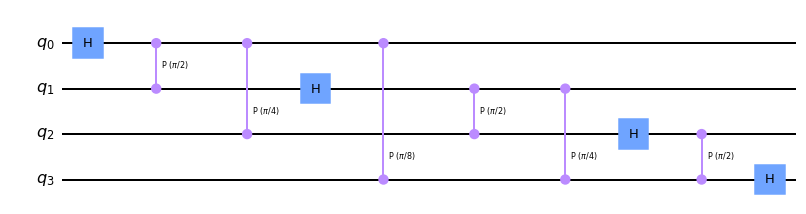

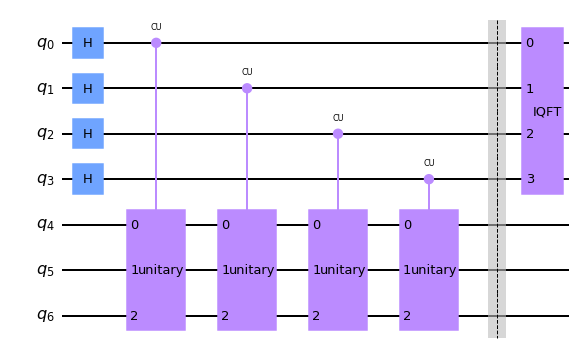

In [36]:
qpe_circ = fast_QPE(precision=4,unitary=q).get_QPE(show=True)

## Attaching the Circuit
- Using the eigenvector $|011 \rangle$ to generate the phase kickback in the Quantum Circuit

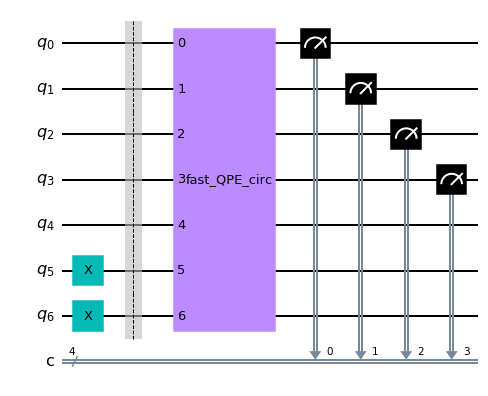

In [37]:
q = QuantumCircuit(7,4)
q.x([5,6])
q.barrier()
q.append(qpe_circ, qargs = [0,1,2,3,4,5,6])
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

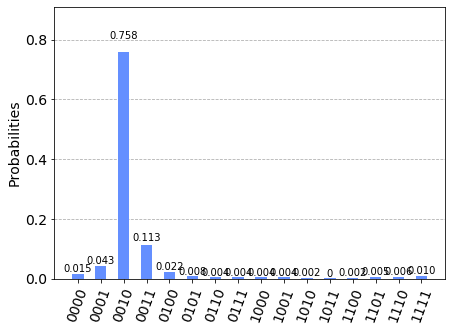

In [38]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)

- Correct output pertaining to phase $\frac{1}{7}$ 

## Arbitrary Placement Circuit

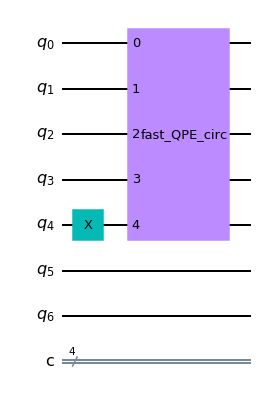

In [45]:
q = QuantumCircuit(7, 4)
q.x(4)
q.append(qpe_circ, qargs=[0, 1, 2, 3, 4])
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

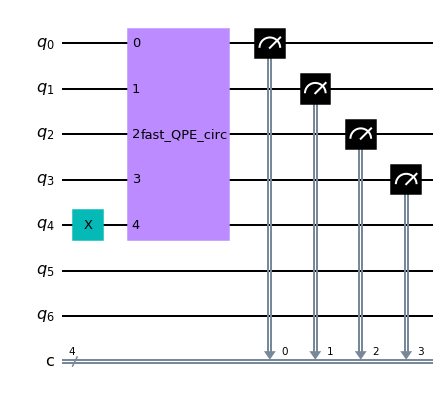

In [46]:
q.measure([0, 1, 2, 3], [0, 1, 2, 3])
q.draw('mpl')

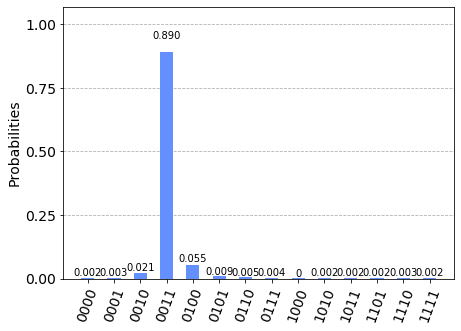

In [47]:
count = execute(q, backend=Aer.get_backend(
    'qasm_simulator')).result().get_counts()
plot_histogram(count)